<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">TFM - Data Mining and Machine Learning </p>
<p style="margin: 0; text-align:right;">2019 · Master in Data science</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Sara Estravís Nieto</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# SC Brain Matrix Classification - global

Experiment 3

Input data: all the nodes with significant values at global level with data from SC matrices.

<ul>
  <li><a href='#dataload'>Data load</a></li>
  <li><a href='#knn'>K-NN</a></li>
  <li><a href='#svm'>SVM</a></li>
  <li><a href='#randomforest'>Random Forest</a></li>
</ul>

In [1]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from time import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import itertools
from sklearn.svm import SVC
from sklearn.utils import shuffle
from scipy.stats import uniform
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

<a id = 'dataload'/>

## Data Load

In [2]:
# Load the csv brain data with the significant variables
data = pd.read_csv("globalSCMatrixSignificantData.csv") 

# Shuffle the data
data = shuffle(data, random_state=0).reset_index(drop=True)
data.head()

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10,Column11,Column12
0,0.099066,14.613449,14.529623,15.778098,13.159139,12.965646,23.882949,12.598318,25.485011,15.244243,15.131265,ms
1,0.102228,15.306174,15.796124,14.042908,11.879391,12.147937,19.474595,13.335961,25.994224,15.821715,14.851769,ms
2,0.077466,18.809321,18.987718,19.107379,16.086686,16.678150,25.897596,18.519867,29.239184,20.218310,20.375064,ms
3,0.098350,15.712585,17.710904,13.780772,13.473397,12.132908,20.844780,11.864315,19.828555,13.947618,13.321698,ms
4,0.114283,12.399773,13.694551,12.909561,10.506384,11.220254,20.154159,11.316898,19.266863,12.928888,12.818160,ms


In [3]:
# Separate the dataframe into nodes_properties (x) and classes (y)
nodes_properties = data.iloc[:,0:len(data.columns)-1]
print('Properties dimensions: ', nodes_properties.shape)

classes = data.iloc[:,len(data.columns)-1]
classes_names = ["hv", "ms"]
n_classes = len(classes_names)
print('Classes dimensions: ', classes.shape)
print('There are {} classes: {}'.format(n_classes, classes_names))

Properties dimensions:  (239, 11)
Classes dimensions:  (239,)
There are 2 classes: ['hv', 'ms']


In [4]:
# Divide the dataframe in the test and train sets, with 80% of the data in the train group and 20% in the test set.
# We will stratify using classes, so that there is the same proportion of each class in the test/train sets as in the original
# dataset
X_train, X_test, y_train, y_test = train_test_split(nodes_properties, classes, test_size=0.2, random_state=2019, stratify=classes)


In [5]:
print('X_train dimensions: ', X_train.shape)
print('y_train dimensions: ', y_train.shape)

print('X_test dimensions: ', X_test.shape)
print('y_test dimensions: ', y_test.shape)

X_train dimensions:  (191, 11)
y_train dimensions:  (191,)
X_test dimensions:  (48, 11)
y_test dimensions:  (48,)


<a id='knn'></a>

## K-NN

#### Hyperparameter tuning

In [6]:
# First of all, create the classifier
knn = KNeighborsClassifier()

# Then, the hyperparameters to be optimized are defined 
# k = number of nearest neighbours considered
# weights = weight function used in prediction. If it is 'uniform', all the neighbours will have the same importance. If it is 
# 'distance', closer neighbours will have more influence. 

k_range = list(range(1, 21))
weight_names = ['uniform', 'distance']

param_grid = dict(n_neighbors=k_range, weights = weight_names)

# Now create the grid search with 4 folds for cross-validation
grid = GridSearchCV(knn, param_grid, cv=4, iid=False)

# Apply the grid to the data checking the time 
start = time()
grid.fit(X_train, y_train)
end = time()

# Check the results
print("The search took {} seconds".format(end - start))
print(" ")

ranks = list(grid.cv_results_['rank_test_score'])
means = list(grid.cv_results_["mean_test_score"])
stds = list(grid.cv_results_["std_test_score"])
params = list(grid.cv_results_['params'])

results = zip (ranks, means, stds, params)
for rank, mean, std, params in results:
    if rank == 1: #If the rank of the result is one, print it
        print("Rank : {}. Mean accuracy {:.4f} +/- {:.4f}. Parameters: {}".format(rank, mean*100, std*100, params))


The search took 1.496764898300171 seconds
 
Rank : 1. Mean accuracy 80.1086 +/- 1.7542. Parameters: {'n_neighbors': 18, 'weights': 'distance'}
Rank : 1. Mean accuracy 80.1086 +/- 1.7542. Parameters: {'n_neighbors': 19, 'weights': 'uniform'}
Rank : 1. Mean accuracy 80.1086 +/- 1.7542. Parameters: {'n_neighbors': 19, 'weights': 'distance'}
Rank : 1. Mean accuracy 80.1086 +/- 1.7542. Parameters: {'n_neighbors': 20, 'weights': 'distance'}


#### Model training with best parameters

In [7]:
# First create and fit the model with the best hyperparameters
knn = KNeighborsClassifier(n_neighbors=grid.best_params_["n_neighbors"], weights=grid.best_params_["weights"])

knn.fit(X_train, y_train)

# Predict the test values
y_predicted = knn.predict(X_test)

# Get the accuracy of the model
accuracy = accuracy_score(y_test, y_predicted)

# Print the results
print("K-NN Algorithm results")
print("-----------------------")
print("Optimal k: {}".format(grid.best_params_["n_neighbors"]))
print("Optimal weights: {}".format(grid.best_params_["weights"]))
print("Accuracy in the test set with the optimal parameters: {:.2f}%".format(accuracy*100))

K-NN Algorithm results
-----------------------
Optimal k: 18
Optimal weights: distance
Accuracy in the test set with the optimal parameters: 81.25%


In [8]:
# Confusion matrix plot function
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

#### Confusion matrix

[[ 0  9]
 [ 0 39]]


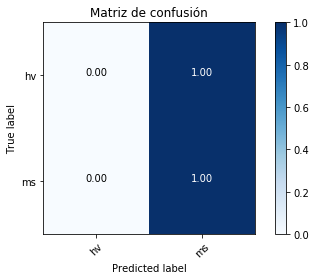

In [9]:
conf_matrix = confusion_matrix(y_test, y_predicted)
print(conf_matrix)

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(conf_matrix, classes=classes_names,
                      title='Matriz de confusión')

<a id='svm'></a>

## SVM

 #### Hyperparameter tuning

In [10]:
# Create the classifier
svm_clasif = SVC(random_state = 1)

# Define the hyperparameters to be optimized
param_dist = dict(C=uniform(1, 100), gamma=uniform(0.001, 1))

# Now create the randomnized search with 4 folds for cross-validation
num_iterations = 100
cv = StratifiedKFold(n_splits=4, shuffle=True)
rand = RandomizedSearchCV(svm_clasif, param_distributions = param_dist, cv=cv, n_iter=num_iterations, iid=False)

# Apply the search to the data checking the time 
start = time()
rand.fit(X_train, y_train)
end = time()

# Check the results
print("The search took {} seconds".format(end - start))
print(" ")

ranks = list(rand.cv_results_['rank_test_score'])
means = list(rand.cv_results_["mean_test_score"])
stds = list(rand.cv_results_["std_test_score"])
params = list(rand.cv_results_['params'])

results = zip (ranks, means, stds, params)
for rank, mean, std, params in results:
    if rank == 1: #If the rank of the result is one, print it
        print("Rank : {}. Mean accuracy {:.4f} +/- {:.4f}. Parameters: {}".format(rank, mean*100, std*100, params))

The search took 3.8523993492126465 seconds
 
Rank : 1. Mean accuracy 81.1503 +/- 0.1727. Parameters: {'C': 93.35197676720443, 'gamma': 0.7336505664751476}
Rank : 1. Mean accuracy 81.1503 +/- 0.1727. Parameters: {'C': 66.92837986320241, 'gamma': 0.7017557694851073}
Rank : 1. Mean accuracy 81.1503 +/- 0.1727. Parameters: {'C': 48.29157418559854, 'gamma': 0.7573412204908442}
Rank : 1. Mean accuracy 81.1503 +/- 0.1727. Parameters: {'C': 1.4572904445497072, 'gamma': 0.8432018418003028}
Rank : 1. Mean accuracy 81.1503 +/- 0.1727. Parameters: {'C': 17.830245001476563, 'gamma': 0.7010489518879537}
Rank : 1. Mean accuracy 81.1503 +/- 0.1727. Parameters: {'C': 71.16908634734236, 'gamma': 0.9319644210240221}
Rank : 1. Mean accuracy 81.1503 +/- 0.1727. Parameters: {'C': 2.110061959322539, 'gamma': 0.7500554587176369}
Rank : 1. Mean accuracy 81.1503 +/- 0.1727. Parameters: {'C': 17.547564464208055, 'gamma': 0.7861435706689077}
Rank : 1. Mean accuracy 81.1503 +/- 0.1727. Parameters: {'C': 7.64718405

#### Train model with best parameters

In [11]:
# Create and fit the model with the best hyperparameters
svm_clasif = SVC(C=rand.best_params_["C"], gamma=rand.best_params_["gamma"])
svm_clasif.fit(X_train, y_train)

# Predict the test values
y_predicted = svm_clasif.predict(X_test)

# Get the accuracy of the model
accuracy = accuracy_score(y_test, y_predicted)

# Print the results
print("SVM Algorithm results")
print("-----------------------")
print("Optimal C: {}".format(rand.best_params_["C"]))
print("Optimal gamma: {}".format(rand.best_params_["gamma"]))
print("Accuracy in the test set with the optimal parameters: {:.2f}%".format(accuracy*100))

SVM Algorithm results
-----------------------
Optimal C: 93.35197676720443
Optimal gamma: 0.7336505664751476
Accuracy in the test set with the optimal parameters: 81.25%


#### Confusion matrix

[[ 0  9]
 [ 0 39]]


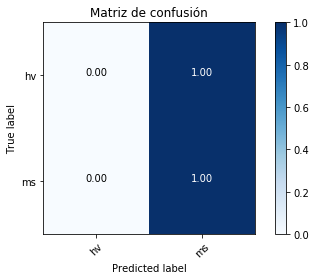

In [12]:
conf_matrix = confusion_matrix(y_test, y_predicted)
print(conf_matrix)

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(conf_matrix, classes=classes_names,
                      title='Matriz de confusión')

<a id='randomforest'></a>

## Random Forest

#### Hyperparameter tuning

In [13]:
# Create the classifier
random_forest = RandomForestClassifier(random_state=0)

# Define the hyperparameters to be optimized 
n_estimators = list(range(1, 61))

param_grid = dict(n_estimators=n_estimators)

# Create the grid search with 4 folds for cross-validation
grid = GridSearchCV(random_forest, param_grid, cv=4, iid=False)

# Apply the grid to the data checking the time 
start = time()
grid.fit(X_train, y_train)
end = time()

# Check the results
print("The search took {} seconds".format(end - start))
print(" ")

ranks = list(grid.cv_results_['rank_test_score'])
means = list(grid.cv_results_["mean_test_score"])
stds = list(grid.cv_results_["std_test_score"])
params = list(grid.cv_results_['params'])

results = zip (ranks, means, stds, params)
for rank, mean, std, params in results:
    if rank == 1: #If the rank of the result is one, print it
        print("Rank : {}. Mean accuracy {:.4f} +/- {:.4f}. Parameters: {}".format(rank, mean*100, std*100, params))


The search took 14.30477523803711 seconds
 
Rank : 1. Mean accuracy 79.0669 +/- 2.4748. Parameters: {'n_estimators': 53}
Rank : 1. Mean accuracy 79.0669 +/- 2.4748. Parameters: {'n_estimators': 55}


#### Train model with best hyperparameters

In [14]:
# Create and fit the model with the best hyperparameters
random_forest = RandomForestClassifier(random_state=0, n_estimators=grid.best_params_["n_estimators"])
random_forest.fit(X_train, y_train)

# Predict the test values
y_predicted = random_forest.predict(X_test)

# Get the accuracy of the model
accuracy = accuracy_score(y_test, y_predicted)

# Print the results
print("Random Forest Algorithm results")
print("-----------------------")
print("Optimal n_estimators: {}".format(grid.best_params_["n_estimators"]))
print("Accuracy in the test set with the optimal parameters: {:.2f}%".format(accuracy*100))

Random Forest Algorithm results
-----------------------
Optimal n_estimators: 53
Accuracy in the test set with the optimal parameters: 77.08%


#### Confusion Matrix

[[ 0  9]
 [ 2 37]]


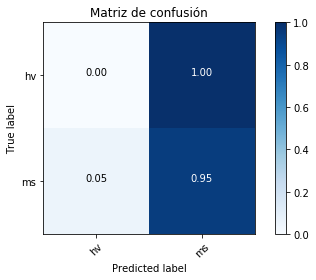

In [15]:
conf_matrix = confusion_matrix(y_test, y_predicted)
print(conf_matrix)

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(conf_matrix, classes=classes_names,
                      title='Matriz de confusión')